In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
mesh=47
y_val = torch.tensor([147])

In [3]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_47/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_'+str(mesh)+'/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

        PCa_b   trpnmax    Gncx_b     Tref    perm50    nperm   TRPN_n  \
0    0.000122  0.079681  0.001599  175.127  0.194890  2.76968  2.59449   
1    0.000094  0.089178  0.001334  174.341  0.388696  2.03769  2.94509   
2    0.000128  0.075311  0.001740  179.916  0.245876  2.36111  2.92207   
3    0.000142  0.122175  0.002428  198.270  0.408520  2.86864  2.84040   
4    0.000095  0.110494  0.001329  165.397  0.282575  2.88664  2.31923   
..        ...       ...       ...      ...       ...      ...      ...   
795  0.000093  0.118370  0.001163  184.647  0.283320  2.99653  2.46956   
796  0.000091  0.079472  0.000975  198.891  0.456715  3.01241  2.07730   
797  0.000147  0.087607  0.001378  195.996  0.213886  2.51946  2.80751   
798  0.000151  0.116453  0.001457  192.469  0.372302  2.74916  2.55940   
799  0.000112  0.073569  0.001336  170.032  0.322520  1.91660  2.91944   

           dr     wfrac    TOT_A  ...    AoPref    PaPref     VePref  \
0    0.200250  0.295068  17.5391  ...  

In [4]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_47/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_'+str(mesh)+'/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

      LVedv  LVedp  LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  RVesv  \
0    126.12  14.48  51.71  190.91       1903      -1004  147.49  15.05  71.91   
1    130.59  14.97  77.74  181.83       3228      -1233  122.13   9.85  67.22   
2    140.46  18.09  67.39   91.30       1718       -817  147.21  22.19  73.38   
3    118.50  21.02  46.92  104.71       2466       -914  149.78  18.21  73.46   
4    102.87  11.39  49.72  116.54       3174       -942  143.04  15.92  75.00   
..      ...    ...    ...     ...        ...        ...     ...    ...    ...   
110  125.01  19.03  58.80  118.33       2673       -845  156.75  21.96  88.32   
111  120.43  13.46  68.18  152.11       2677       -968  127.38   9.64  74.77   
112  104.91  10.88  46.52  128.42       3085      -1069  129.12   8.54  62.52   
113  140.56  22.89  77.98  260.87       4125      -1792  134.84  13.34  70.58   
114  100.59  15.57  38.03  127.89       3230       -882  136.91   9.96  71.52   

     RVpMax  ...  RAvMax  R

# Emulator

In [5]:
y_all.max()

LVedv         158.530
LVedp          32.430
LVesv          91.260
LVpMax        260.870
LVdpdtMax    4419.000
LVdpdtMin    -351.000
RVedv         191.360
RVedp          31.700
RVesv          95.370
RVpMax         92.390
RVdpdtMax    1190.000
RVdpdtMin    -166.000
LAedv          61.830
LAesv          55.590
LAvMax         81.810
LApMax         32.340
RAedv          68.850
RAesv          56.940
RAvMax         86.220
RApMax         30.620
LAsvA          16.710
LAinflV        22.810
LAsvV          22.880
RAsvA          21.880
RAinflV        20.390
RAsvV          21.400
A_TAT         165.190
V_TAT         110.775
dtype: float64

In [6]:
input_masked = X_all.copy()

In [7]:
y_all

,LVedv,LVedp,LVesv,LVpMax,LVdpdtMax,LVdpdtMin,RVedv,RVedp,RVesv,RVpMax,...,RAvMax,RApMax,LAsvA,LAinflV,LAsvV,RAsvA,RAinflV,RAsvV,A_TAT,V_TAT
0,126.12,14.48,51.71,190.91,1903,-1004,147.49,15.05,71.91,65.32,...,69.47,14.85,13.41,9.87,9.93,18.94,8.75,11.33,126.700,90.6829
1,130.59,14.97,77.74,181.83,3228,-1233,122.13,9.85,67.22,49.67,...,64.42,9.55,5.80,7.82,7.74,6.11,8.20,8.68,131.971,90.2363
2,140.46,18.09,67.39,91.30,1718,-817,147.21,22.19,73.38,50.45,...,70.21,21.87,3.91,16.72,16.66,5.73,9.97,10.19,150.992,106.3080
3,118.50,21.02,46.92,104.71,2466,-914,149.78,18.21,73.46,49.76,...,68.95,17.76,6.05,9.89,9.64,7.54,7.62,9.35,121.213,93.5512
4,102.87,11.39,49.72,116.54,3174,-942,143.04,15.92,75.00,43.76,...,68.49,15.43,4.63,8.17,7.70,7.34,7.89,9.48,150.880,88.6315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,125.01,19.03,58.80,118.33,2673,-845,156.75,21.96,88.32,70.10,...,70.60,21.60,3.34,12.58,12.49,4.71,9.33,9.45,159.029,90.5629
111,120.43,13.46,68.18,152.11,2677,-968,127.38,9.64,74.77,42.48,...,67.83,9.36,8.68,9.23,9.20,10.62,10.01,10.22,149.493,97.1730
112,104.91,10.88,46.52,128.42,3085,-1069,129.12,8.54,62.52,40.72,...,63.85,8.59,5.94,17.16,20.37,10.89,5.69,6.95,125.552,87.3617
113,140.56,22.89,77.98,260.87,4125,-1792,134.84,13.34,70.58,51.07,...,64.96,13.18,12.17,10.59,10.48,12.90,7.62,7.82,141.996,99.1240


In [8]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(X_all[0:y_all.shape[0]].values)

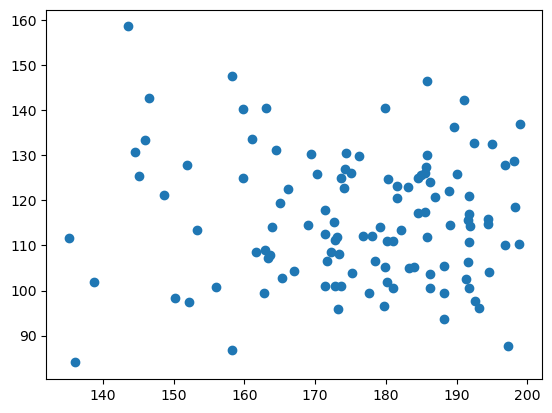

In [9]:
plt.plot(x_train[:,3],y_train[:,0],'o')

In [77]:
reps= 1
for i in range(reps):    
    X=x_train
    y=y_train[:,[3]]
    x_train2, x_test, y_train2, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    emulator = GPE.ensemble(x_train2,y_train2,mean_func="linear",training_iter=1000);
    print(emulator.R2(x_test,y_test))

0
tensor([0.3183], dtype=torch.float64, grad_fn=<RsubBackward1>)


In [56]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [57]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[5.83464e-05, 0.0001541]
[0.0625116, 0.123227]
[0.000921633, 0.00251189]
[135.206, 199.704]
[0.175616, 0.52417]
[1.56262, 3.0434]
[1.86623, 2.9983]
[0.125877, 0.367901]
[0.251546, 0.747163]
[12.6117, 37.3455]
[0.0111953, 0.0314906]
[0.404971, 1.06197]
[1.50081, 4.48294]
[0.00298001, 0.00748154]
[0.0351425, 0.104365]
[0.0810012, 0.184816]
[50.3602, 149.375]
[0.180935, 0.522955]
[2.51645, 7.43799]
[1.04007, 2.97164]
[0.126018, 0.372123]
[0.25082, 0.747605]
[12.6298, 37.4525]
[1.12051, 3.3262]
[0.433656, 1.28857]
[4.51488, 13.481]
[0.673456, 0.836114]
[0.470936, 0.644581]
[100, 200]
[0.108252, 4.99241]
[0.10743, 4.9969]
[254.56, 1499.78]
[251.214, 1497.05]
[151.104, 999.063]
[151.546, 999.663]
[150.165, 999.612]
[57.4508, 159.391]
[4.06892, 78.9918]
[0.521288, 23.9784]
[4.00529, 11.973]
[0.504022, 4.99966]
[1.50083, 5.99971]
[0.000507773, 0.0499326]
[0.50057, 0.999325]
[8.03514, 27.9561]
[4.1008, 7.69434]


In [58]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_75567/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [59]:
data1.shape

torch.Size([96256, 46])

In [67]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                           ST   ST_conf
(PCa_b,)             0.003000  0.000294
(trpnmax,)           0.036496  0.003148
(Gncx_b,)            0.000713  0.000061
(Tref,)              0.040278  0.003861
(perm50,)            0.048040  0.003935
(nperm,)             0.021957  0.002030
(TRPN_n,)            0.065064  0.006522
(dr,)                0.016142  0.001475
(wfrac,)             0.021236  0.001939
(TOT_A,)             0.006122  0.000668
(ktm_unblock,)       0.000057  0.000005
(ca50,)              0.006388  0.000652
(mu,)                0.004438  0.000397
(maxI_up,)           0.113182  0.009779
(maxTrpn,)           0.029855  0.002871
(g_CaL,)             0.008374  0.000712
(Tref,)              0.009921  0.001030
(perm50,)            0.059028  0.006036
(nperm,)             0.002481  0.000218
(TRPN_n,)            0.082797  0.007418
(dr,)                0.003355  0.000304
(wfrac,)             0.003253  0.000319
(TOT_A,)             0.002229  0.000203
(phi,)               0.004871  0.000514


                           ST   ST_conf
(PCa_b,)             0.149057  0.014634
(trpnmax,)           0.011329  0.000991
(Gncx_b,)            0.017317  0.001632
(Tref,)              0.017040  0.001622
(perm50,)            0.001441  0.000128
(nperm,)             0.081660  0.007944
(TRPN_n,)            0.100399  0.009036
(dr,)                0.019127  0.001500
(wfrac,)             0.030882  0.002965
(TOT_A,)             0.005852  0.000581
(ktm_unblock,)       0.007258  0.000698
(ca50,)              0.041692  0.004142
(mu,)                0.000294  0.000028
(maxI_up,)           0.012309  0.001141
(maxTrpn,)           0.004711  0.000418
(g_CaL,)             0.000771  0.000071
(Tref,)              0.013316  0.001267
(perm50,)            0.007933  0.000721
(nperm,)             0.000751  0.000070
(TRPN_n,)            0.004481  0.000369
(dr,)                0.006590  0.000737
(wfrac,)             0.054873  0.005806
(TOT_A,)             0.007870  0.000662
(phi,)               0.001118  0.000097


                           ST       ST_conf
(PCa_b,)             0.065723  6.108689e-03
(trpnmax,)           0.049157  3.999140e-03
(Gncx_b,)            0.010833  9.565045e-04
(Tref,)              0.059481  5.251207e-03
(perm50,)            0.017379  1.565256e-03
(nperm,)             0.023976  2.038720e-03
(TRPN_n,)            0.009438  9.934180e-04
(dr,)                0.018866  1.604805e-03
(wfrac,)             0.000060  5.482089e-06
(TOT_A,)             0.000050  4.490288e-06
(ktm_unblock,)       0.017435  1.694248e-03
(ca50,)              0.009098  8.516751e-04
(mu,)                0.005844  5.694889e-04
(maxI_up,)           0.040118  3.760483e-03
(maxTrpn,)           0.185972  1.582761e-02
(g_CaL,)             0.017534  1.611374e-03
(Tref,)              0.015190  1.301620e-03
(perm50,)            0.000321  3.080539e-05
(nperm,)             0.000680  6.483677e-05
(TRPN_n,)            0.041000  3.516602e-03
(dr,)                0.009334  9.130621e-04
(wfrac,)             0.022429  1

                           ST       ST_conf
(PCa_b,)             0.000863  8.462305e-05
(trpnmax,)           0.097765  9.358131e-03
(Gncx_b,)            0.023475  2.324688e-03
(Tref,)              0.039781  3.787870e-03
(perm50,)            0.001659  1.475518e-04
(nperm,)             0.087483  7.493461e-03
(TRPN_n,)            0.013422  1.277961e-03
(dr,)                0.009033  8.693144e-04
(wfrac,)             0.003460  3.366729e-04
(TOT_A,)             0.002561  2.456254e-04
(ktm_unblock,)       0.014446  1.318041e-03
(ca50,)              0.035485  3.731404e-03
(mu,)                0.008201  7.589263e-04
(maxI_up,)           0.064156  6.330803e-03
(maxTrpn,)           0.017549  1.633268e-03
(g_CaL,)             0.008616  7.816561e-04
(Tref,)              0.000722  6.698446e-05
(perm50,)            0.014689  1.490984e-03
(nperm,)             0.006702  6.600422e-04
(TRPN_n,)            0.150732  1.332594e-02
(dr,)                0.011491  1.086432e-03
(wfrac,)             0.007010  5

                               ST       ST_conf
(PCa_b,)             1.406687e-04  1.325512e-05
(trpnmax,)           2.711169e-03  2.205386e-04
(Gncx_b,)            9.296524e-03  9.720873e-04
(Tref,)              8.597336e-02  8.250254e-03
(perm50,)            6.214921e-02  4.625531e-03
(nperm,)             3.927044e-04  3.723023e-05
(TRPN_n,)            2.270877e-03  1.951881e-04
(dr,)                8.206504e-03  7.289304e-04
(wfrac,)             4.462935e-03  4.414851e-04
(TOT_A,)             3.959961e-04  3.643497e-05
(ktm_unblock,)       8.535222e-03  8.177332e-04
(ca50,)              8.939749e-04  8.251516e-05
(mu,)                2.200498e-03  2.203627e-04
(maxI_up,)           1.375516e-01  1.299142e-02
(maxTrpn,)           5.071663e-03  4.768895e-04
(g_CaL,)             1.244760e-02  1.118583e-03
(Tref,)              4.349449e-03  3.728164e-04
(perm50,)            5.806854e-02  5.509700e-03
(nperm,)             9.611449e-04  8.844790e-05
(TRPN_n,)            1.405540e-01  1.276

                           ST   ST_conf
(PCa_b,)             0.025138  0.002281
(trpnmax,)           0.000976  0.000089
(Gncx_b,)            0.030456  0.002916
(Tref,)              0.024687  0.002481
(perm50,)            0.074810  0.006647
(nperm,)             0.026641  0.002850
(TRPN_n,)            0.007001  0.000622
(dr,)                0.002404  0.000221
(wfrac,)             0.004123  0.000393
(TOT_A,)             0.001593  0.000155
(ktm_unblock,)       0.000045  0.000004
(ca50,)              0.021419  0.002207
(mu,)                0.002560  0.000244
(maxI_up,)           0.121216  0.011485
(maxTrpn,)           0.039262  0.003708
(g_CaL,)             0.016686  0.001808
(Tref,)              0.006300  0.000598
(perm50,)            0.071575  0.007035
(nperm,)             0.000531  0.000055
(TRPN_n,)            0.120569  0.010829
(dr,)                0.005741  0.000571
(wfrac,)             0.000080  0.000008
(TOT_A,)             0.012504  0.001131
(phi,)               0.002062  0.000211


                               ST       ST_conf
(PCa_b,)             3.558901e-03  3.469555e-04
(trpnmax,)           1.402469e-04  1.185419e-05
(Gncx_b,)            1.450988e-03  1.507218e-04
(Tref,)              7.588505e-04  7.668607e-05
(perm50,)            3.208077e-03  2.928584e-04
(nperm,)             1.423736e-01  1.122755e-02
(TRPN_n,)            9.627141e-03  9.111029e-04
(dr,)                4.959425e-03  5.131296e-04
(wfrac,)             2.692545e-03  2.771247e-04
(TOT_A,)             4.793896e-05  4.943800e-06
(ktm_unblock,)       8.061850e-02  7.512954e-03
(ca50,)              2.632563e-03  2.298483e-04
(mu,)                7.318764e-03  7.117031e-04
(maxI_up,)           1.708066e-03  1.694513e-04
(maxTrpn,)           2.104152e-02  1.814860e-03
(g_CaL,)             2.405974e-04  2.156741e-05
(Tref,)              1.328124e-02  1.310775e-03
(perm50,)            8.675616e-03  9.105570e-04
(nperm,)             1.703934e-03  1.716419e-04
(TRPN_n,)            1.372495e-01  1.289

                           ST   ST_conf
(PCa_b,)             0.029897  0.002942
(trpnmax,)           0.003059  0.000256
(Gncx_b,)            0.006661  0.000608
(Tref,)              0.001256  0.000135
(perm50,)            0.091537  0.009778
(nperm,)             0.021711  0.002008
(TRPN_n,)            0.039828  0.003584
(dr,)                0.060856  0.005379
(wfrac,)             0.014284  0.001355
(TOT_A,)             0.002223  0.000193
(ktm_unblock,)       0.000039  0.000004
(ca50,)              0.026728  0.002427
(mu,)                0.025216  0.002278
(maxI_up,)           0.102644  0.010219
(maxTrpn,)           0.130812  0.012124
(g_CaL,)             0.011357  0.000998
(Tref,)              0.036707  0.003301
(perm50,)            0.000542  0.000051
(nperm,)             0.001729  0.000173
(TRPN_n,)            0.045936  0.003832
(dr,)                0.006111  0.000557
(wfrac,)             0.018652  0.001887
(TOT_A,)             0.013994  0.001374
(phi,)               0.005718  0.000517


                           ST   ST_conf
(PCa_b,)             0.066276  0.006134
(trpnmax,)           0.012218  0.001120
(Gncx_b,)            0.033899  0.003400
(Tref,)              0.000162  0.000016
(perm50,)            0.054001  0.004437
(nperm,)             0.107879  0.011185
(TRPN_n,)            0.012319  0.001216
(dr,)                0.000145  0.000013
(wfrac,)             0.002170  0.000207
(TOT_A,)             0.009278  0.000814
(ktm_unblock,)       0.005762  0.000557
(ca50,)              0.037469  0.003560
(mu,)                0.000934  0.000089
(maxI_up,)           0.055686  0.005309
(maxTrpn,)           0.063395  0.005544
(g_CaL,)             0.019921  0.002071
(Tref,)              0.007885  0.000799
(perm50,)            0.077806  0.007608
(nperm,)             0.005145  0.000488
(TRPN_n,)            0.076474  0.008348
(dr,)                0.014011  0.001521
(wfrac,)             0.000345  0.000031
(TOT_A,)             0.010046  0.000954
(phi,)               0.009528  0.000804


                               ST       ST_conf
(PCa_b,)             1.327418e-01  1.183171e-02
(trpnmax,)           1.891142e-02  1.707381e-03
(Gncx_b,)            1.090076e-01  1.045332e-02
(Tref,)              4.162541e-03  4.027007e-04
(perm50,)            1.500157e-01  1.564510e-02
(nperm,)             2.511292e-03  2.498267e-04
(TRPN_n,)            3.229714e-08  2.880783e-09
(dr,)                3.667768e-02  3.606923e-03
(wfrac,)             2.300975e-03  2.053773e-04
(TOT_A,)             3.170992e-02  3.161910e-03
(ktm_unblock,)       1.457755e-02  1.390444e-03
(ca50,)              1.278586e-01  1.082675e-02
(mu,)                9.471148e-03  9.448431e-04
(maxI_up,)           5.453719e-02  5.089725e-03
(maxTrpn,)           6.426039e-02  6.757187e-03
(g_CaL,)             1.110568e-02  1.047049e-03
(Tref,)              7.041897e-04  6.897091e-05
(perm50,)            3.379815e-04  3.615661e-05
(nperm,)             9.766541e-04  8.666773e-05
(TRPN_n,)            9.180801e-03  7.568

                           ST   ST_conf
(PCa_b,)             0.040541  0.003609
(trpnmax,)           0.025245  0.002368
(Gncx_b,)            0.003961  0.000385
(Tref,)              0.000228  0.000019
(perm50,)            0.100837  0.009105
(nperm,)             0.030879  0.002691
(TRPN_n,)            0.095363  0.008622
(dr,)                0.102710  0.009445
(wfrac,)             0.000209  0.000019
(TOT_A,)             0.008725  0.000821
(ktm_unblock,)       0.011113  0.000949
(ca50,)              0.130507  0.012183
(mu,)                0.018918  0.001724
(maxI_up,)           0.049154  0.004994
(maxTrpn,)           0.065704  0.006089
(g_CaL,)             0.010543  0.000995
(Tref,)              0.036064  0.003135
(perm50,)            0.023467  0.002095
(nperm,)             0.001431  0.000121
(TRPN_n,)            0.005447  0.000495
(dr,)                0.019097  0.001646
(wfrac,)             0.016307  0.001540
(TOT_A,)             0.006723  0.000582
(phi,)               0.014748  0.001468


In [68]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [69]:
x_labels.values.squeeze().tolist()

['PCa_b',
 'trpnmax',
 'Gncx_b',
 'Tref',
 'perm50',
 'nperm',
 'TRPN_n',
 'dr',
 'wfrac',
 'TOT_A',
 'ktm_unblock',
 'ca50',
 'mu',
 'maxI_up',
 'maxTrpn',
 'g_CaL',
 'Tref',
 'perm50',
 'nperm',
 'TRPN_n',
 'dr',
 'wfrac',
 'TOT_A',
 'phi',
 'ca50',
 'mu',
 'CV_ventricles',
 'CV_atria',
 'AV_delay',
 'Rsys',
 'Rpulm',
 'mitral_area',
 'tricuspid_area',
 'aortic_area',
 'sysOrifice_area',
 'pulmOrifice_area',
 'AoPref',
 'PaPref',
 'VePref',
 'kArt',
 'a_ventricles',
 'a_atria',
 'k_peri',
 'Tref_lvrv',
 'EDP_lv',
 'EDP_rv']

In [70]:
y_all.columns.tolist()

['LVedv',
 'LVedp',
 'LVesv',
 'LVpMax',
 'LVdpdtMax',
 'LVdpdtMin',
 'RVedv',
 'RVedp',
 'RVesv',
 'RVpMax',
 'RVdpdtMax',
 'RVdpdtMin',
 'LAedv',
 'LAesv',
 'LAvMax',
 'LApMax',
 'RAedv',
 'RAesv',
 'RAvMax',
 'RApMax',
 'LAsvA',
 'LAinflV',
 'LAsvV',
 'RAsvA',
 'RAinflV',
 'RAsvV',
 'A_TAT',
 'V_TAT']

In [71]:
['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

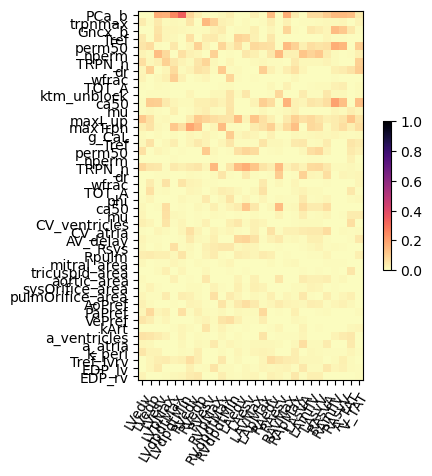

In [74]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first,cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

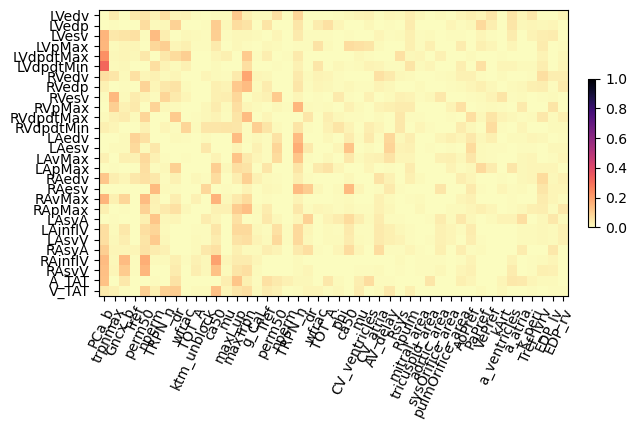

In [75]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [22]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [23]:
boundsMaxMin

[[5.83464e-05, 0.0001541],
 [0.0625116, 0.123227],
 [0.000921633, 0.00251189],
 [135.206, 199.704],
 [0.175616, 0.52417],
 [1.56262, 3.0434],
 [1.86623, 2.9983],
 [0.125877, 0.367901],
 [0.251546, 0.747163],
 [12.6117, 37.3455],
 [0.0111953, 0.0314906],
 [0.404971, 1.06197],
 [1.50081, 4.48294],
 [0.00298001, 0.00748154],
 [0.0351425, 0.104365],
 [0.0810012, 0.184816],
 [50.3602, 149.375],
 [0.180935, 0.522955],
 [2.51645, 7.43799],
 [1.04007, 2.97164],
 [0.126018, 0.372123],
 [0.25082, 0.747605],
 [12.6298, 37.4525],
 [1.12051, 3.3262],
 [0.433656, 1.28857],
 [4.51488, 13.481],
 [0.673456, 0.836114],
 [0.470936, 0.644581],
 [100, 200],
 [0.108252, 4.99241],
 [0.10743, 4.9969],
 [254.56, 1499.78],
 [251.214, 1497.05],
 [151.104, 999.063],
 [151.546, 999.663],
 [150.165, 999.612],
 [57.4508, 159.391],
 [4.06892, 78.9918],
 [0.521288, 23.9784],
 [4.00529, 11.973],
 [0.504022, 4.99966],
 [1.50083, 5.99971],
 [0.000507773, 0.0499326],
 [0.50057, 0.999325],
 [8.03514, 27.9561],
 [4.1008, 7.

In [24]:
centre[[1,2,4,5,]]

array([9.2869300e-02, 1.7167615e-03, 3.4989300e-01, 2.3030100e+00])

In [25]:
boundsMaxMin=np.array(boundsMaxMin)

In [26]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        return 0.0
    return -np.inf

In [76]:
def log_likelihood(x,emulator,y_val,obs_error):
    x=torch.tensor(x)[None]
    with gpytorch.settings.fast_pred_var(): #This line makes it fast!
        ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],obs_error)).detach().numpy())
    return ll

In [28]:
def log_prob(theta, emulator,y_val,obs_error):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta,emulator, y_val,obs_error)

In [29]:
import emcee

In [79]:
emulator = GPE.ensemble(x_train,y_train[:,[3]],mean_func="linear",training_iter=1000)

0


In [80]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 100
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
#y_val = torch.tensor([80,134])
obs_error=((y_val*0.05))**2

In [81]:
y_val+2*((y_val*0.05))

tensor([161.7000])

In [82]:
y_val*0.18

tensor([26.4600])

In [83]:
obs_error

tensor([54.0225])

In [84]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val,obs_error])

sampler.run_mcmc(p0, 40000,progress=True)

100%|███████████████████████████████████| 40000/40000 [16:41<00:00, 39.95it/s]


State([[6.78109414e-05 7.63308788e-02 2.44255505e-03 ... 6.97361951e-01
  1.25140828e+01 7.65638687e+00]
 [1.39831340e-04 8.51341594e-02 1.90244262e-03 ... 5.65326331e-01
  2.06317741e+01 7.56839128e+00]
 [1.27881392e-04 7.44433454e-02 1.92213811e-03 ... 5.76690567e-01
  2.25097524e+01 4.53088140e+00]
 ...
 [1.17843397e-04 6.48670038e-02 1.48236175e-03 ... 5.45988517e-01
  2.00104457e+01 4.51626611e+00]
 [7.85983836e-05 1.04636256e-01 1.88559735e-03 ... 5.33587067e-01
  1.25893970e+01 7.25767209e+00]
 [6.99819091e-05 1.17765830e-01 2.27345308e-03 ... 8.39501515e-01
  2.60460351e+01 7.27112110e+00]], log_prob=[-4.44978619 -4.2586956  -4.79567814 -5.39736271 -4.20404625 -6.82849407
 -7.78278923 -4.21196127 -6.93311691 -4.20181656 -5.34043598 -4.80912542
 -9.81684589 -6.01782608 -4.70349598 -4.23617363 -4.44817591 -7.75883007
 -4.16078377 -6.99531078 -4.26188803 -7.49018383 -4.18161488 -4.36297941
 -4.80596018 -5.18284988 -5.55519819 -4.22605705 -4.30877399 -4.79887581
 -4.93863773 -4.433

In [85]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

(200000, 46)


In [86]:
boundsMaxMin

[[5.83464e-05, 0.0001541],
 [0.0625116, 0.123227],
 [0.000921633, 0.00251189],
 [135.206, 199.704],
 [0.175616, 0.52417],
 [1.56262, 3.0434],
 [1.86623, 2.9983],
 [0.125877, 0.367901],
 [0.251546, 0.747163],
 [12.6117, 37.3455],
 [0.0111953, 0.0314906],
 [0.404971, 1.06197],
 [1.50081, 4.48294],
 [0.00298001, 0.00748154],
 [0.0351425, 0.104365],
 [0.0810012, 0.184816],
 [50.3602, 149.375],
 [0.180935, 0.522955],
 [2.51645, 7.43799],
 [1.04007, 2.97164],
 [0.126018, 0.372123],
 [0.25082, 0.747605],
 [12.6298, 37.4525],
 [1.12051, 3.3262],
 [0.433656, 1.28857],
 [4.51488, 13.481],
 [0.673456, 0.836114],
 [0.470936, 0.644581],
 [100, 200],
 [0.108252, 4.99241],
 [0.10743, 4.9969],
 [254.56, 1499.78],
 [251.214, 1497.05],
 [151.104, 999.063],
 [151.546, 999.663],
 [150.165, 999.612],
 [57.4508, 159.391],
 [4.06892, 78.9918],
 [0.521288, 23.9784],
 [4.00529, 11.973],
 [0.504022, 4.99966],
 [1.50083, 5.99971],
 [0.000507773, 0.0499326],
 [0.50057, 0.999325],
 [8.03514, 27.9561],
 [4.1008, 7.

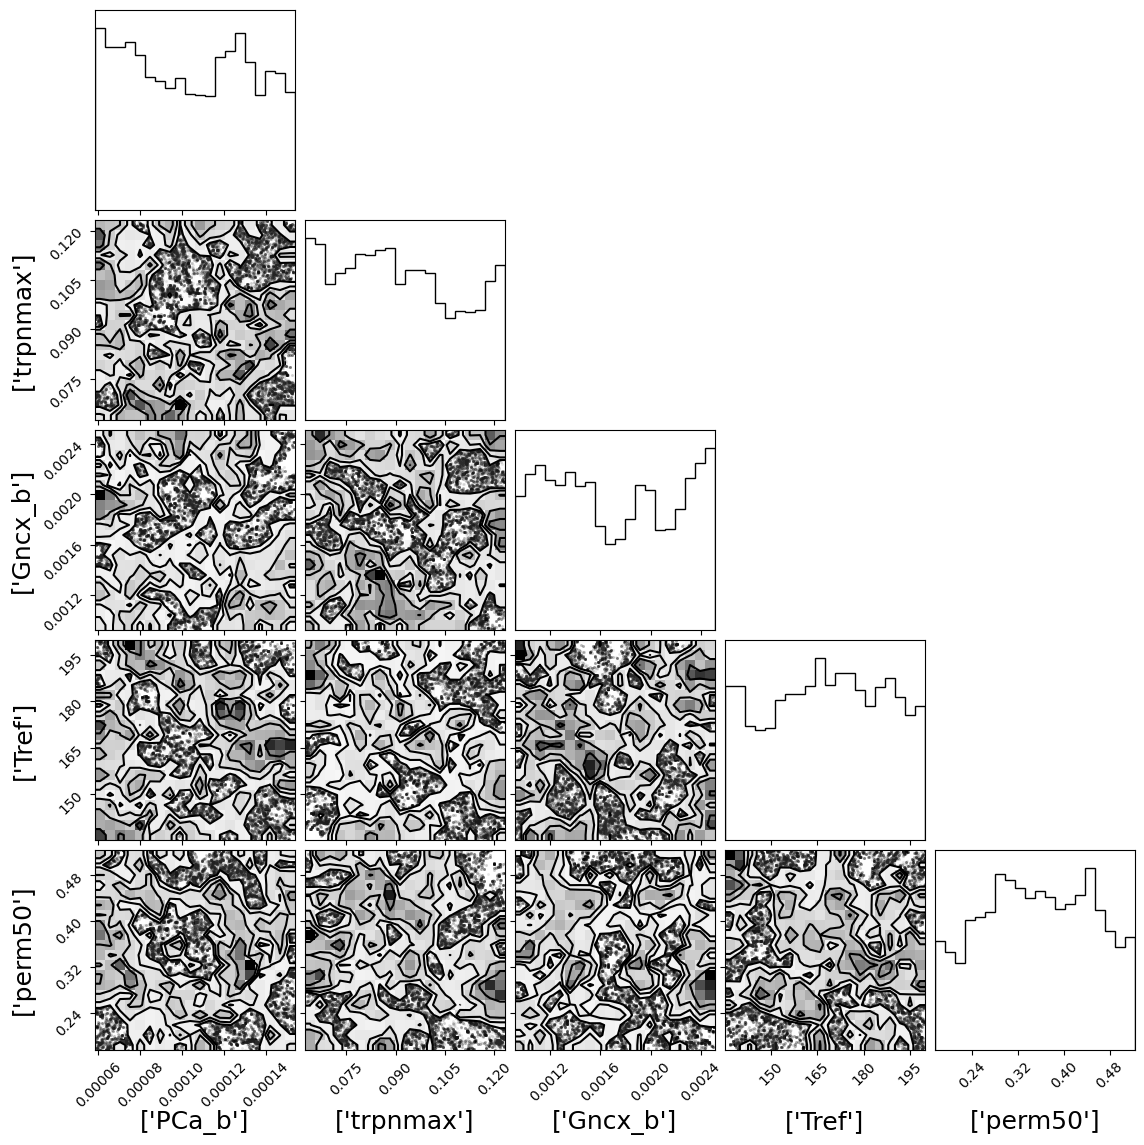

In [96]:
import corner

fig = corner.corner(
    flat_samples[:,0:5], labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

(array([ 2682., 13263., 23967., 33325., 60378., 41080., 14360.,  6590.,
         3822.,   533.]),
 array([ 58.31375885,  75.01973724,  91.72571564, 108.43169403,
        125.13767242, 141.84365845, 158.54963684, 175.25561523,
        191.96159363, 208.66757202, 225.37355042]),
 <BarContainer object of 10 artists>)

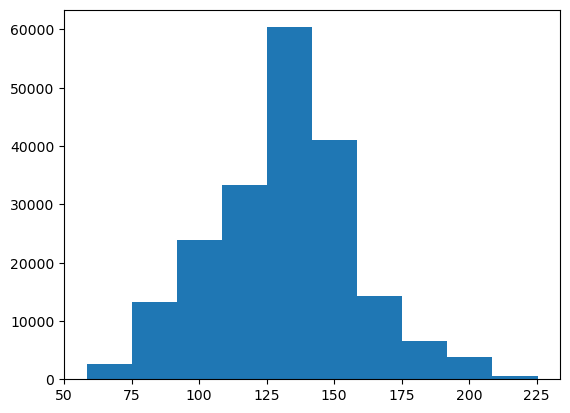

In [88]:
plt.hist(emulator.predict(torch.tensor(flat_samples)).detach().numpy()[:,0])

In [89]:
emulator.predict(torch.tensor(flat_samples)).mean(axis=0)

tensor([131.3923], grad_fn=<MeanBackward1>)

In [90]:
emulator.predict(torch.tensor(flat_samples)).std(axis=0)

tensor([26.5897], grad_fn=<StdBackward0>)

In [91]:
y_val*0.05

tensor([7.3500])

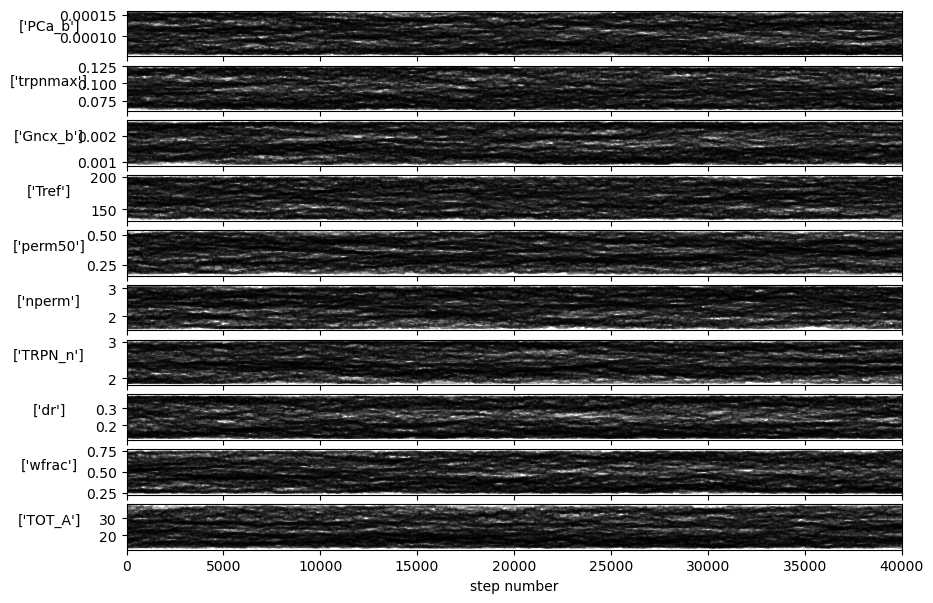

In [92]:
fig, axes = plt.subplots(10, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(10):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [95]:
y_train[:,3].mean()

tensor(125.2247, dtype=torch.float64)

In [44]:
flat_samples.mean(axis=0)-flat_samples.std(axis=0)

array([7.97954059e-05, 7.84244868e-02, 1.17820346e-03, 1.47120700e+02,
       2.59226563e-01, 1.94298187e+00, 2.13595920e+00, 1.78134943e-01,
       3.97256252e-01, 1.92119031e+01, 1.52057912e-02, 5.44472970e-01,
       2.11158406e+00, 3.84775074e-03, 5.21475485e-02, 1.04480835e-01,
       7.33053285e+01, 2.48866860e-01, 3.77997030e+00, 1.37082929e+00,
       1.72221897e-01, 4.01031634e-01, 1.70494234e+01, 1.62257363e+00,
       6.26386365e-01, 6.55826212e+00, 6.95739665e-01, 5.11995652e-01,
       1.19889035e+02, 1.06417364e+00, 1.29474987e+00, 5.61683202e+02,
       5.24401919e+02, 3.17146995e+02, 2.85543022e+02, 3.12327295e+02,
       7.69447515e+01, 1.99548258e+01, 6.98251428e+00, 5.63903920e+00,
       1.28348867e+00, 2.51904955e+00, 1.11802504e-02, 6.24508464e-01,
       1.25353108e+01, 4.85948368e+00])

In [45]:
flat_samples.mean(axis=0)+flat_samples.std(axis=0)

array([1.34593661e-04, 1.14191332e-01, 2.11562449e-03, 1.85637292e+02,
       4.41468482e-01, 2.76836790e+00, 2.73377999e+00, 3.19844068e-01,
       6.83143024e-01, 3.36979392e+01, 2.80832211e-02, 9.42419886e-01,
       3.82730919e+00, 6.51018984e-03, 9.19833982e-02, 1.62499166e-01,
       1.29996120e+02, 4.51595740e-01, 6.50712143e+00, 2.51002959e+00,
       3.11246843e-01, 6.56412657e-01, 3.18394027e+01, 2.89874224e+00,
       1.12374756e+00, 1.15986102e+01, 7.95064893e-01, 6.06621507e-01,
       1.78442260e+02, 3.80880591e+00, 3.99594956e+00, 1.28457971e+03,
       1.23615002e+03, 8.22961941e+02, 7.75737628e+02, 8.05526416e+02,
       1.32929299e+02, 6.12680427e+01, 2.00830580e+01, 1.05364755e+01,
       3.95129588e+00, 4.97190273e+00, 4.14659483e-02, 8.91478512e-01,
       2.38275980e+01, 7.01257917e+00])

In [46]:
boundsMaxMin

array([[5.83464e-05, 1.54100e-04],
       [6.25116e-02, 1.23227e-01],
       [9.21633e-04, 2.51189e-03],
       [1.35206e+02, 1.99704e+02],
       [1.75616e-01, 5.24170e-01],
       [1.56262e+00, 3.04340e+00],
       [1.86623e+00, 2.99830e+00],
       [1.25877e-01, 3.67901e-01],
       [2.51546e-01, 7.47163e-01],
       [1.26117e+01, 3.73455e+01],
       [1.11953e-02, 3.14906e-02],
       [4.04971e-01, 1.06197e+00],
       [1.50081e+00, 4.48294e+00],
       [2.98001e-03, 7.48154e-03],
       [3.51425e-02, 1.04365e-01],
       [8.10012e-02, 1.84816e-01],
       [5.03602e+01, 1.49375e+02],
       [1.80935e-01, 5.22955e-01],
       [2.51645e+00, 7.43799e+00],
       [1.04007e+00, 2.97164e+00],
       [1.26018e-01, 3.72123e-01],
       [2.50820e-01, 7.47605e-01],
       [1.26298e+01, 3.74525e+01],
       [1.12051e+00, 3.32620e+00],
       [4.33656e-01, 1.28857e+00],
       [4.51488e+00, 1.34810e+01],
       [6.73456e-01, 8.36114e-01],
       [4.70936e-01, 6.44581e-01],
       [1.00000e+02,

In [47]:
emulator.predict(torch.tensor(flat_samples.mean(axis=0))[None])

tensor([[130.8404]], grad_fn=<PermuteBackward0>)

In [48]:
torch.tensor(flat_samples.mean(axis=0))[None]

tensor([[1.0719e-04, 9.6308e-02, 1.6469e-03, 1.6638e+02, 3.5035e-01, 2.3557e+00,
         2.4349e+00, 2.4899e-01, 5.4020e-01, 2.6455e+01, 2.1645e-02, 7.4345e-01,
         2.9694e+00, 5.1790e-03, 7.2065e-02, 1.3349e-01, 1.0165e+02, 3.5023e-01,
         5.1435e+00, 1.9404e+00, 2.4173e-01, 5.2872e-01, 2.4444e+01, 2.2607e+00,
         8.7507e-01, 9.0784e+00, 7.4540e-01, 5.5931e-01, 1.4917e+02, 2.4365e+00,
         2.6453e+00, 9.2313e+02, 8.8028e+02, 5.7005e+02, 5.3064e+02, 5.5893e+02,
         1.0494e+02, 4.0611e+01, 1.3533e+01, 8.0878e+00, 2.6174e+00, 3.7455e+00,
         2.6323e-02, 7.5799e-01, 1.8181e+01, 5.9360e+00]], dtype=torch.float64)